In [ ]:
from google.colab import drive
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

!git clone https://github.com/Jaeyoon-Park/project01
%cd project01

Mounted at /content/drive


1. Preprocess : 인식을 위한 Mask 만들기

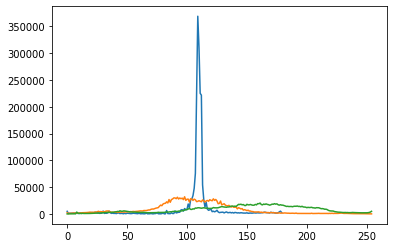

In [ ]:
img = cv2.imread("head attack sample.jpg")

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hist_h = cv2.calcHist([img_hsv], [0], None, [180], [0, 180])
hist_s = cv2.calcHist([img_hsv], [1], None, [255], [0, 255])
hist_v = cv2.calcHist([img_hsv], [2], None, [255], [0, 255])

plt.plot(hist_h) # blue line 
plt.plot(hist_s) # orange line
plt.plot(hist_v) # green line
plt.show()

In [ ]:
slider_Hmin = widgets.IntSlider(value=0, max=180)
display(slider_Hmin)
slider_Hmax = widgets.IntSlider(value=180, max=180)
display(slider_Hmax)

IntSlider(value=0, max=180)

IntSlider(value=180, max=180)

In [ ]:
slider_Smin = widgets.IntSlider(value=0, max=255)
display(slider_Smin)
slider_Smax = widgets.IntSlider(value=255, max=255)
display(slider_Smax)

IntSlider(value=0, max=255)

IntSlider(value=255, max=255)

In [ ]:
slider_Vmin = widgets.IntSlider(value=0, max=255)
display(slider_Vmin)
slider_Vmax = widgets.IntSlider(value=255, max=255)
display(slider_Vmax)

IntSlider(value=0, max=255)

IntSlider(value=255, max=255)

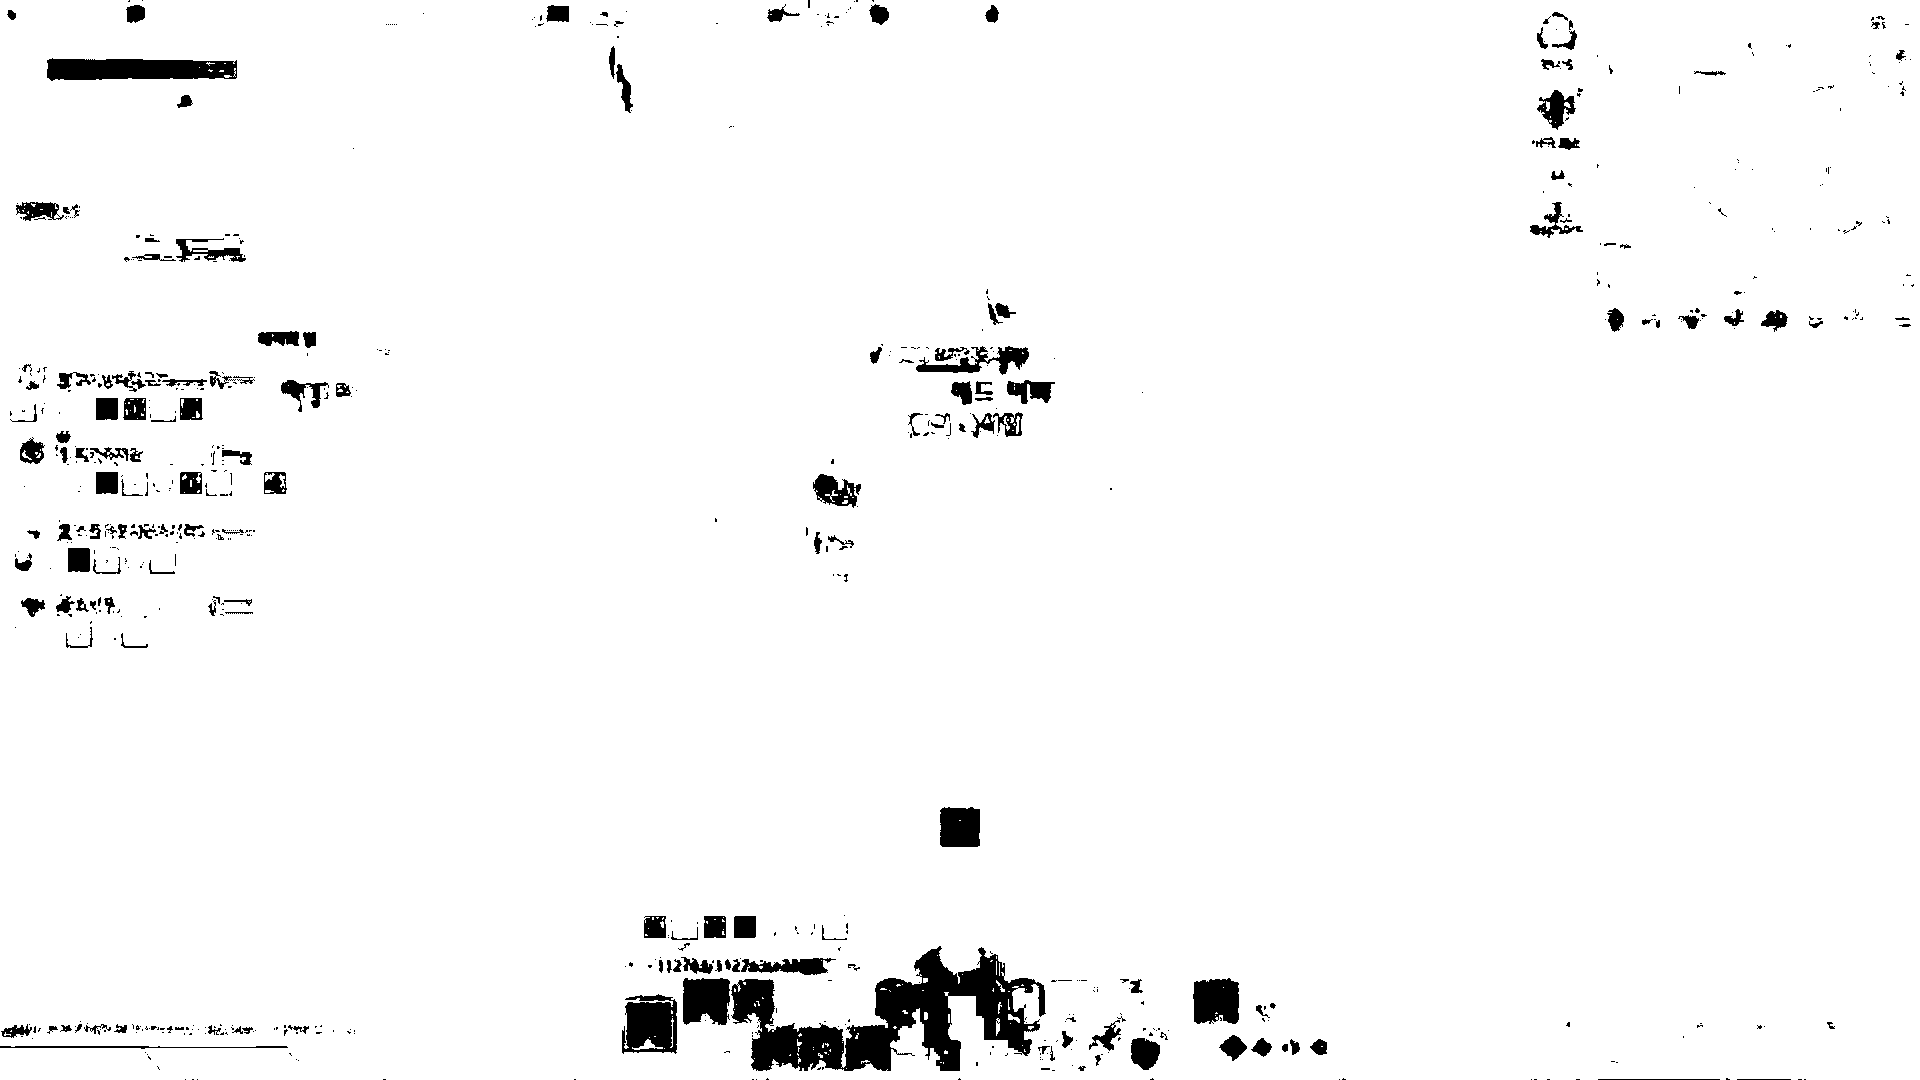

In [ ]:
dst_hsv = cv2.inRange(img_hsv, (slider_Hmin.value, slider_Smin.value, slider_Vmin.value), (slider_Hmax.value, slider_Smax.value, slider_Vmax.value))
cv2_imshow(dst_hsv)

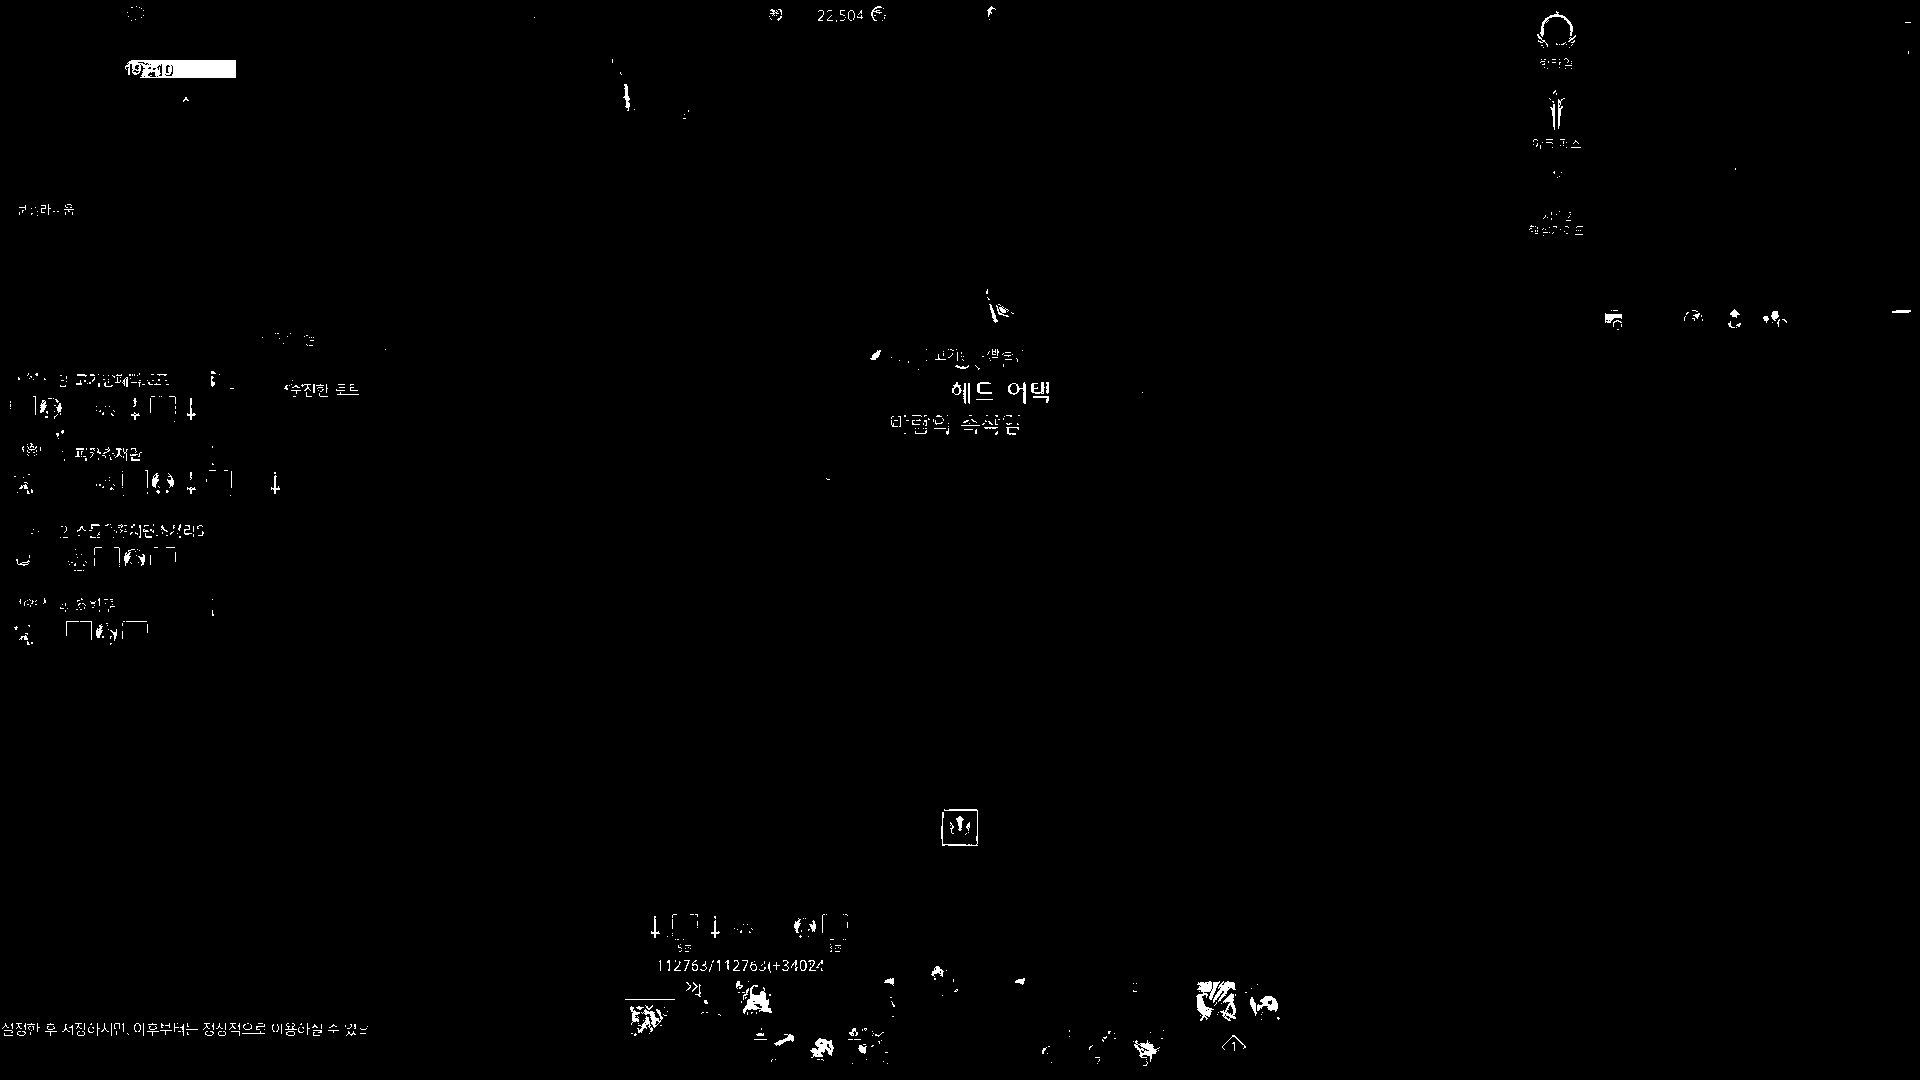

In [ ]:
# 아래의 범위에서 "헤드어택" 문구가 제일 잘 보임
mask_hsv = cv2.inRange(img_hsv, (0, 15, 220), (40, 155, 255))
cv2_imshow(mask_hsv)

2. 영상 불러오기

In [ ]:
capture = cv2.VideoCapture("lostark sample.mp4")

capture_w = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
capture_h = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
capture_total_frame = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

fps = capture.get(cv2.CAP_PROP_FPS)

print("{0} x {1}".format(capture_w, capture_h))
print(capture_total_frame)
print(fps)

1920 x 1080
8407
29.978643737677537


3. Head Attack 비율을 확인하고자 하는 스킬 선택

In [ ]:
list_skill_alpha = ["Q", "W", "E", "R",
                    "A", "S", "D", "F"]

list_skill = [(682, 978, 45, 45), (729, 978, 45, 45), (776, 978, 45, 45), (823, 815, 45, 45),
              (704, 1025, 45, 45), (751, 1025, 45, 45), (798, 1025, 45, 45), (845, 1025, 45, 45)]

# 확인하고자 하는 스킬 입력
input_skill = input("확인하려는 스킬은? ")

sk_idx = 0
while input_skill != list_skill_alpha[sk_idx]:
    sk_idx = sk_idx+1

roi_x1 = int(list_skill[sk_idx][0])
roi_x2 = int(list_skill[sk_idx][0]+list_skill[sk_idx][2])

roi_y1 = int(list_skill[sk_idx][1])
roi_y2 = int(list_skill[sk_idx][1]+list_skill[sk_idx][3])

확인하려는 스킬은? S


4. 스킬 사용 프레임 탐색

In [ ]:
# 배경 설정
capture.set(cv2.CAP_PROP_POS_FRAMES, 840)
_, bg = capture.read()
img_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
roi_bg = img_bg[roi_y1:roi_y2, roi_x1:roi_x2] # (y, x)
cut_bg = img_bg[0:25, 110:333]

# 프레임 초기화
capture.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [ ]:
skill_use_frame_mean_list = [0]
cutscene_mean_list = [0]
skill_use_frame_idx_list = []

for i in range(1, int(capture_total_frame)):
    run, frame = capture.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    roi = img[roi_y1:roi_y2, roi_x1:roi_x2] # (y, x)
    cut = img[0:25, 110:333]

    skill_use = cv2.absdiff(roi, roi_bg)
    mean_value_skill_use = float(cv2.mean(skill_use)[0])
    #skill_used = float(cv2.mean(skill_use)[0])

    cutscene_diff = cv2.absdiff(cut, cut_bg)
    cutscene_chk = float(cv2.mean(cutscene_diff)[0])

    skill_use_frame_mean_list.append(mean_value_skill_use)
    skill_used = abs(skill_use_frame_mean_list[i-1]-skill_use_frame_mean_list[i])
    
    cutscene_mean_list.append(cutscene_chk)
    cutscene = abs(cutscene_mean_list[i-1]-cutscene_mean_list[i])
    
    if skill_used > 70 and cutscene < 30:
      print(capture.get(cv2.CAP_PROP_POS_FRAMES))
      print(skill_used)
      print(cutscene)
      skill_use_frame_idx_list.append(int(capture.get(cv2.CAP_PROP_POS_FRAMES)))
      cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

5. Mask 적용 및 Template Matching

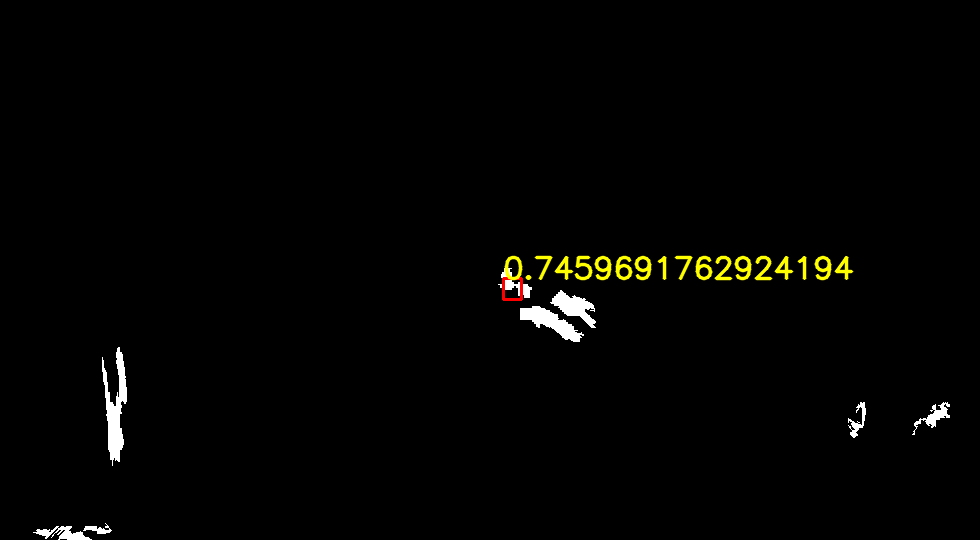

detected


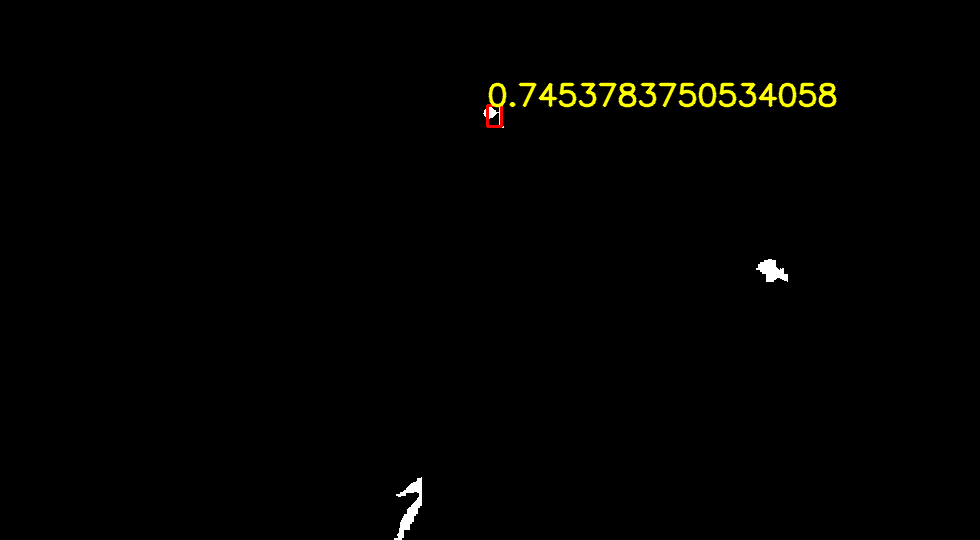

detected


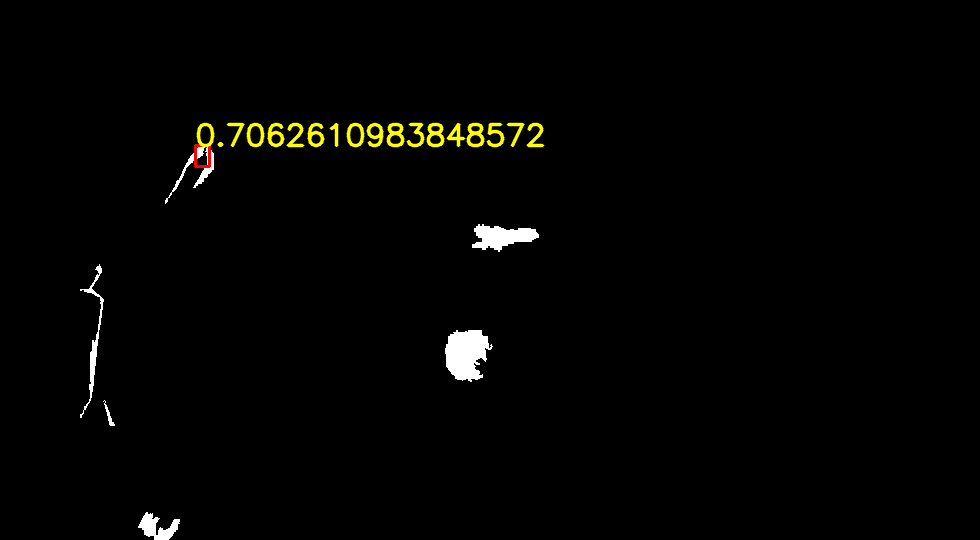

detected


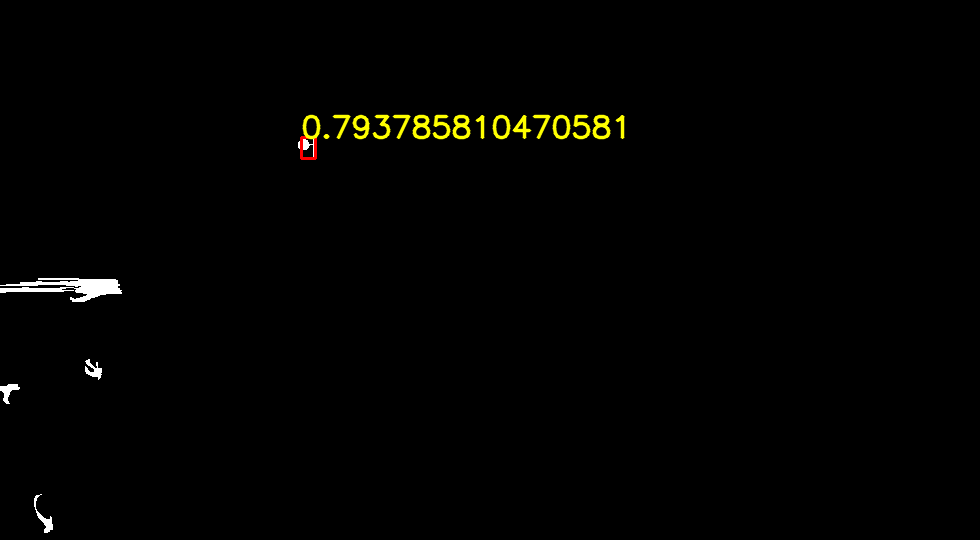

detected


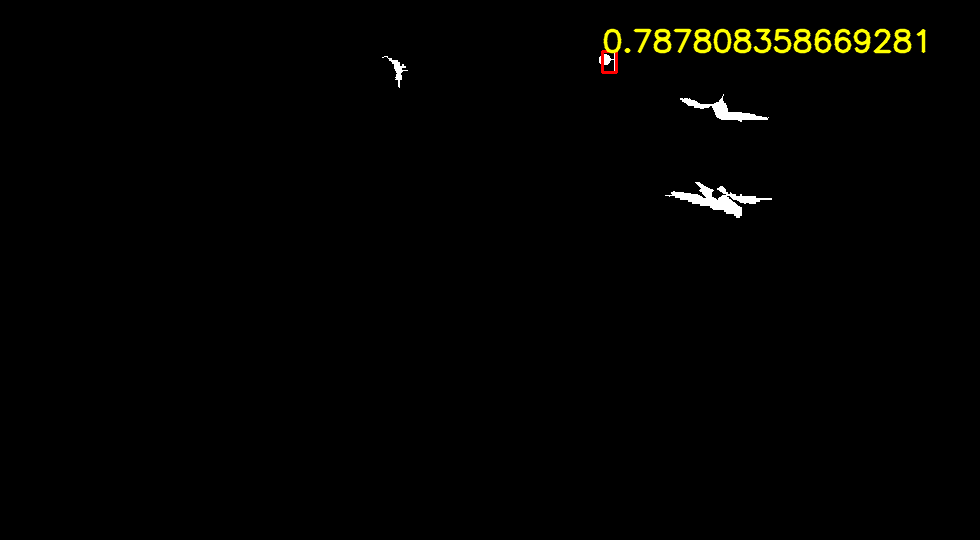

detected


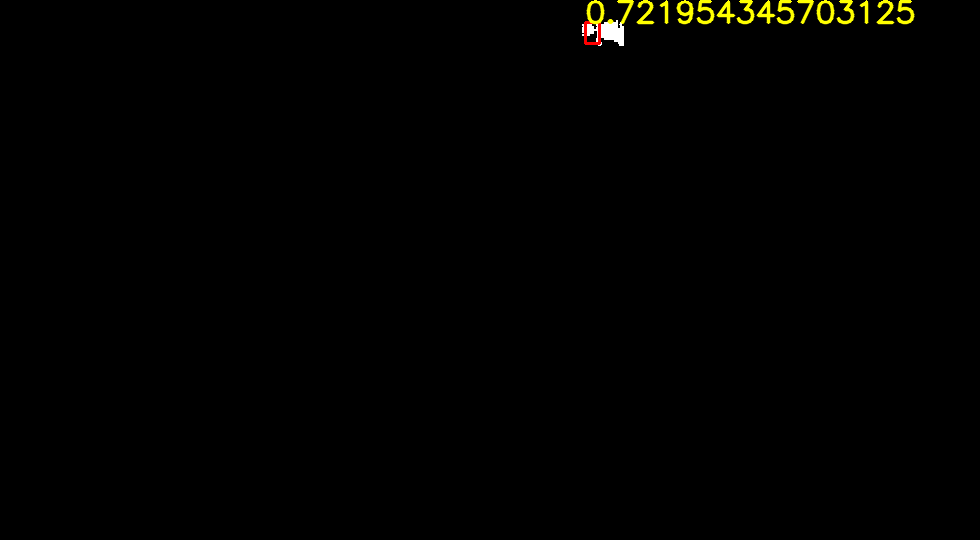

detected


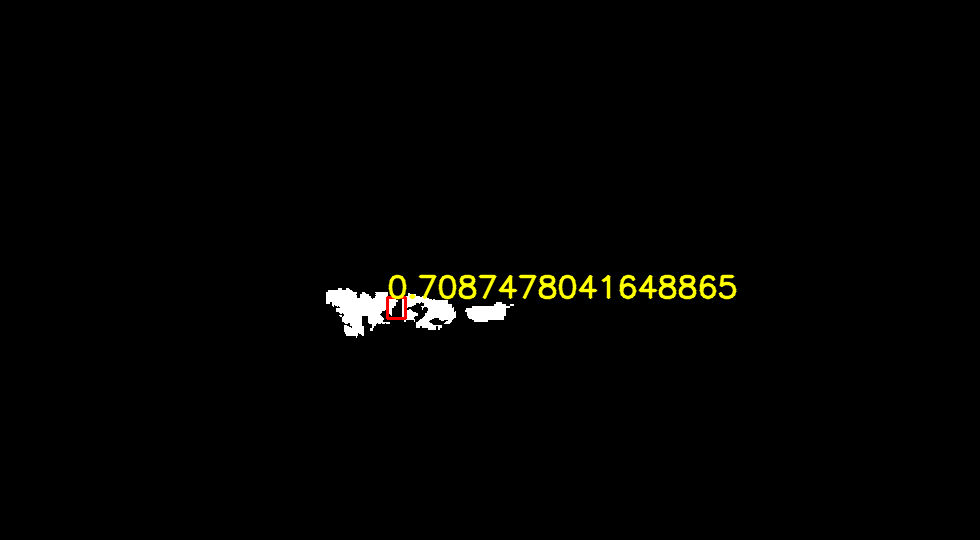

detected
7
7
1.0


In [ ]:
headcnt = 0

for i in range(len(skill_use_frame_idx_list)):
    capture.set(cv2.CAP_PROP_POS_FRAMES, int(skill_use_frame_idx_list[i])+10)
    while True:
      run2, frame2 = capture.read()

      if i < len(skill_use_frame_idx_list)-1:
        if skill_use_frame_idx_list[i+1] - skill_use_frame_idx_list[i] > 60:
          magic_num = 60
        else:
          magic_num = int((skill_use_frame_idx_list[i+1] - skill_use_frame_idx_list[i])/2)

      if capture.get(cv2.CAP_PROP_POS_FRAMES) >= int(skill_use_frame_idx_list[i]+magic_num):
        break
      if capture.get(cv2.CAP_PROP_POS_FRAMES) == capture_total_frame:
        break

      src2 = cv2.bilateralFilter(frame2, -1, 1, 3)
      src_hsv = cv2.cvtColor(src2, cv2.COLOR_BGR2HSV)
      dst_hsv = cv2.inRange(src_hsv, (0, 15, 200), (40, 155, 255))

      src3 = frame2[270:810, 490:1470]
      mask = dst_hsv[270:810, 490:1470]
      h, w = mask.shape[:2]
      mask_bgr = np.zeros((h, w, 3), np.uint8)
      contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

      idx = 0
      chkpoint = False
      for pts in contours:
        x, y, w, h = cv2.boundingRect(pts)
        cv2.rectangle(src3, (x, y), (x+w, y+h), (0, 255, 255), 1)
        area = w*h
        
        if area > 300 and area < 4000:
            cv2.rectangle(src3, (x, y), (x+w, y+h), (0, 0, 255), 3)
            #cv2_imshow(src3)
            cv2.drawContours(mask_bgr, contours, idx, (255, 255, 255), -1)
            #cv2_imshow(mask_bgr)
            mask_bgr_1C = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
            for i in range(7):
              templ = cv2.imread(str("tmp{}.jpg".format(i+1)), cv2.IMREAD_GRAYSCALE)
              res = cv2.matchTemplate(mask_bgr_1C, templ, cv2.TM_CCOEFF_NORMED)
              _, maxv, _, maxloc = cv2.minMaxLoc(res)

              if maxv < 0.7:
                  continue

              th, tw = templ.shape[:2]
              dst = cv2.cvtColor(mask_bgr_1C, cv2.COLOR_GRAY2BGR)
              cv2.rectangle(dst, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)
              cv2.putText(dst, str(maxv), maxloc, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
              cv2_imshow(dst)
              chkpoint = True
              print("detected")
              headcnt = headcnt + 1
              break
        idx = idx+1
        if chkpoint:
          break 
      if chkpoint:
        break     

print(headcnt)
print(len(skill_use_frame_idx_list))
print(headcnt/len(skill_use_frame_idx_list))